# Transfer learning 

Каждый раз, обучая нейронку, мы сначала рандомно инициализируем веса, а после в ходе бэкпропа обучаем модель. Если мы сразу же угадываем хорошие веса, модель сходится быстрее. Иногда можно брать в качестве инициализации веса, полученные другими исследователями и на их основе дообучать модель под свой выход. Это здорово упрощает задачу обучения и экономит многие часы работы.

Transfer learning это когда ты берёшь чужую модель и адаптируешь её под свою задачу. В этой тетрадке мы  посмотрим на то, как в tensorflow можно этим заняться.

# 1. Я реквизирую эту VGG-16

В прошлый раз мы обсуждали то, как люди Imagenet рвали. Там мы посмотрели на архитектуру VGG-16. Именно её мы попроубем использовать для transfer learning в первой части этой тетрадки. 

<img align="center" src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-neural-network-1-e1542973058418.jpg" width="500">

In [1]:
import tensorflow as tf

print(tf.__version__)

1.13.1


Первый способ использовать предобученные веса - просто взять их из библиотеки через Keras API. Он автоматически скачает их и положит в модель. 

## 1.1 Скачиваем и балуемся 

In [2]:
from tensorflow.python.keras.applications import VGG16

model = VGG16(include_top=True, weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


Опция `weights` отвечает за то, на каком датасете предобучена модель. Опция `include_top` отвечает за то, скачиваем мы модель полностью или только `feature extractor`, то есть только первые слои. Мы скачали всё. Теперь давайте попробуем взять какое-нибудь изображение и посмотреть какой прогноз для него построит наша моделька. 

Для этого нам нужно понять какую именно размерность на вход принимает наша нейронка. Во-первых, мы можем посмотреть на `summary` модели и узнать размерность из него. 

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Во-вторых, мы можем выдернуть её непосредственно из модели. 

In [4]:
model.layers[0].output_shape

(None, 224, 224, 3)

In [5]:
input_shape = model.layers[0].output_shape[1:3]
input_shape

(224, 224)

Теперь попробуем что-нибудь спрогнозировать. В модуле `keras.utis` есть функция `get_file`, которая умеет скачивать и разархивировать разные файлы. Будем использовать её для скачки картинок по ссылкам. 

/Users/fulyankin/.keras/datasets/image.jpg


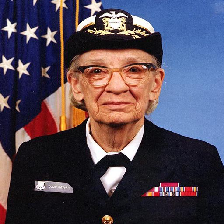

In [6]:
import PIL.Image
import numpy as np

href = 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg'
grace_hopper = tf.keras.utils.get_file('image.jpg', href)

print(grace_hopper) # куда скачался то?! 

grace_hopper = PIL.Image.open(grace_hopper).resize(input_shape)
grace_hopper 

In [7]:
# немного предобработки
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [8]:
# вот так можно добавить фиктивную размерность
grace_hopper[np.newaxis, ...].shape

(1, 224, 224, 3)

In [9]:
# строим прогноз 
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1000)

Готово! У нас есть $1000$ вариантов прогноза. Если быть более конкретным, нас в случае данного изображения устраивает класс номер

In [10]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

669

In [11]:
result[0].argsort()[-5:][::-1] # топ-5 классов

array([669, 999, 794, 549, 529])

Осталось только выяснить что это за класс. Для этого нам нужны метки Imagenet. Скачаем их. Они тоже уже есть в пакете. Удобно. 

In [12]:
from tensorflow.python.keras.applications.vgg16 import decode_predictions
decode_predictions(result)[0]

[('n03788365', 'mosquito_net', 0.1505853),
 ('n15075141', 'toilet_tissue', 0.056366745),
 ('n04209239', 'shower_curtain', 0.0408444),
 ('n03291819', 'envelope', 0.021711731),
 ('n03188531', 'diaper', 0.015669376)]

Напишем функцию для строительства прогнозов и попробуем ещё. 

In [17]:
import matplotlib.pyplot as plt

def save_image(href, save_name):
    img = tf.keras.utils.get_file(save_name, href)
    return img
    
def predict(image_path):
    # Подгружаем изображение и делаем его ресайз в соответсвии с моделью
    img = PIL.Image.open(image_path)
    
    # тут чуть подрбнее про ресайзы: https://habr.com/ru/post/247219/
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Рисуем картинку
    plt.imshow(img_resized)
    plt.show()

    # Кнвертируем картинку в numpy и делаем лишнюю размерность
    img_array = np.array(img_resized)[np.newaxis, ...]

    # VGG-16 строит нам прогноз
    pred = model.predict(img_array)
    
    # Декодируем прогноз
    pred_decoded = decode_predictions(pred)[0]

    # Печатаем его на экран
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

In [20]:
href = 'https://static-eu.insales.ru/images/products/1/7397/80076005/greipfrut.jpeg'
path = save_image(href, 'imgage.jpg')
path

131072/124234 [===============================] - 0s 1us/step


'/Users/fulyankin/.keras/datasets/imgage.jpg'

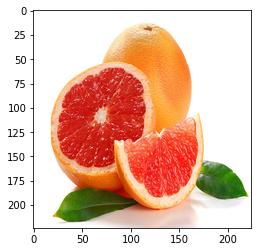

48.74% : face_powder
15.90% : gasmask
 5.76% : thimble
 4.63% : hair_slide
 3.89% : spotlight


In [21]:
predict(path)

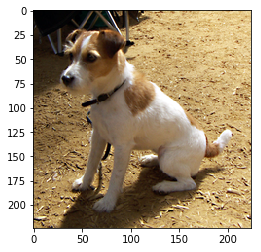

21.06% : American_Staffordshire_terrier
17.63% : Staffordshire_bullterrier
13.81% : toy_terrier
 8.60% : miniature_schnauzer
 8.36% : boxer


In [22]:
href = 'https://upload.wikimedia.org/wikipedia/commons/e/e7/Jack-Russell-Terrier.jpg'
path = save_image(href, 'img_dog.jpg')
predict(path)

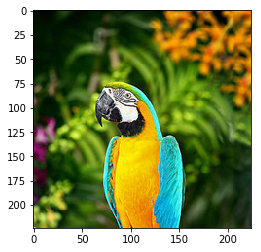

79.02% : macaw
 6.61% : bubble
 3.64% : vine_snake
 1.90% : pinwheel
 1.22% : knot


In [23]:
href = 'https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/images/parrot_cropped1.jpg'
path = save_image(href, 'parrot.jpg')
predict(path)

Обратите внимание, что когда мы делаем `.resize`, мы используем опцию `PIL.Image.LANCZOS` она делает кое-какие приятные ништяки, связанные с защитой изображения от искажений. Вообще борьба с искажениями и разными размерностями у картинок - один из этапов предобработки. 

Как добиться того, чтобы картинка не искажалась? Использовать какие-то похожие фильры, либо обрезать картинки. Давайте попробуем написать в numpy функцию, которая будет заниматься обрезанием картинок вот по такой схеме: 

<img src="https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/week3/images/center_crop.jpg" style="width:50%">

Попробуйте самостоятельно сделать её.

In [24]:
# Функция для обрезания картинок 
def image_center_crop(img):
    w = img.shape[0]
    h = img.shape[1]
    if w > h :
        cropped_img = img[(w-h)//2:w-(w-h)//2,:,:]
    elif w < h:
        cropped_img = img[:,(h-w)//2:h-(h-w)//2,:]
    else:
        cropped_img = img
    return cropped_img

Теперь найлите в интернете какую-нибудь картинку и зашвырните её в сетку без обрезания, а потом с обрезанием. Посмотрите на вероятность, с которой картинка относится к какому-то классу. Функцию `predict`, кстати говоря, придётся переписать. 

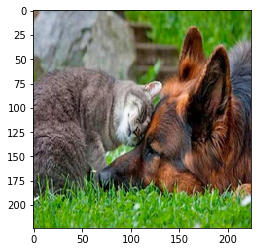

54.56% : timber_wolf
15.09% : coyote
13.45% : red_wolf
 6.30% : wombat
 3.05% : white_wolf


In [25]:
href = 'https://img.pravda.ru/image/preview/article/3/6/4/1042364_five.jpeg'

path = save_image(href, 'cat_dog_full.jpg')
predict(path)

In [26]:
def predict(image_path):
    # Подгружаем изображение и делаем его ресайз в соответсвии с моделью
    img = PIL.Image.open(image_path)
    
    # переделали в массив, обрезали 
    img = image_center_crop(np.array(img)) 
    
    # вернули назад в картинку, сделали resize 
    img_resized = PIL.Image.fromarray(img).resize(input_shape)

    # Рисуем картинку
    plt.imshow(img_resized)
    plt.show()

    # Кнвертируем картинку в numpy и делаем лишнюю размерность
    img_array = np.array(img_resized)[np.newaxis, ...]

    # VGG-16 строит нам прогноз
    pred = model.predict(img_array)
    
    # Декодируем прогноз
    pred_decoded = decode_predictions(pred)[0]

    # Печатаем его на экран
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

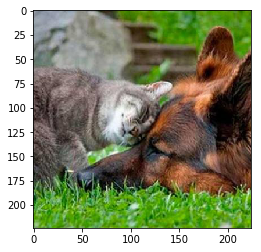

22.89% : wombat
21.85% : timber_wolf
16.65% : brown_bear
10.17% : cougar
 5.63% : ice_bear


In [27]:
href = 'https://img.pravda.ru/image/preview/article/3/6/4/1042364_five.jpeg'

path = save_image(href, 'cat_dog_full.jpg')
predict(path)

## 1.2 Генератор для считывания данных

Окей! Давайте теперь попробуем применить нашу модель для классификации объектов из какого-нибудь большого датасета. 
Например, для классического [датасета с цветами.](https://www.tensorflow.org/tutorials/images/hub_with_keras) Не совсем конечно Фишера, но тоже неплохо. Для начала скачаем его на свой компьютер. Снова нам помогают волшебные функции для этого. 

In [28]:
data_root = tf.keras.utils.get_file(
  'flower_photos',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

In [29]:
# А куда всё скачалось то? 
data_root

'/Users/fulyankin/.keras/datasets/flower_photos'

Мы будем считывать данные из папки с нашего компьютера. Забивать оперативную память лишними гигабайтами картинок не очень хочется. Поэтому мы поступим иначе. Напишем генератор, который будет считывать картинки из памяти по одной. В итоге мы будем считывать картинку, обрабатывать и выбрасывать её из оперативки навсегда. 

Вы уже в курсе, что у Keras есть свой внутренний API, который позволяет выстраивать пайплайны для работы с данными. Вы уже однажды использовали его, когда в домашке для CIFAR-10 пытлись сделать аугментацию. Именно этот генератор мы и будем использовать сейчас. 

In [30]:
# Снова идём в керасовский модуль и берём из него функцию для генератора
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(rescale=1/255)

# натравливаем гинератор на конкретную директорию c данными
image_data = image_generator.flow_from_directory(data_root)

Found 3670 images belonging to 5 classes.


Посмотрим на характеристики батчей, которые лежат внутри генератора. 

In [31]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Labe batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 256, 256, 3)
Labe batch shape:  (32, 5)


Беда. Размерности не те у картинок, нужны то другие. 

In [32]:
input_shape

(224, 224)

Немного подравим генератор. 

In [33]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=input_shape)

for image_batch,label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Labe batch shape: ", label_batch.shape)
    break

Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 5)


Можно посмотреть на число шагов, которое собрался делать генератор. 

In [34]:
image_data.n

3670

А ещё на названия классов. 

In [35]:
image_data.class_indices.keys()

dict_keys(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])

Давайте прогоним текущий батч через нейронку и посмотрим на прогнозы. 

In [36]:
# построим прогнозы по батчу из картинок
result_batch = model.predict(image_batch)

In [37]:
# што там у нас спрогнозировалось? 
labels_batch = [item[0] for item in decode_predictions(result_batch)]

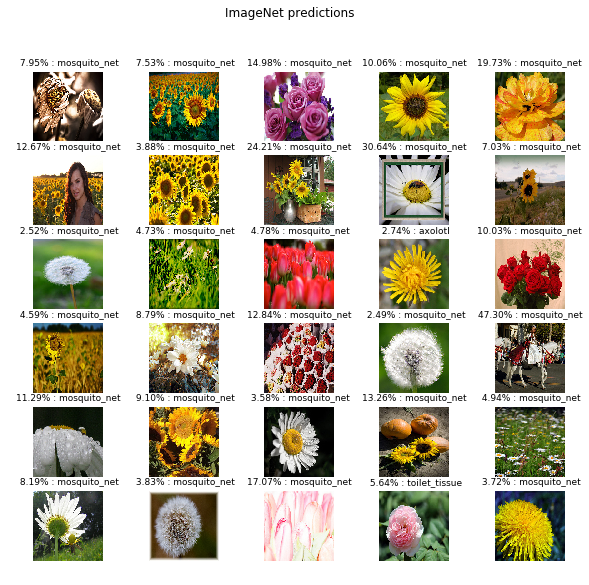

In [38]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title("{0:>6.2%} : {1}".format(labels_batch[n][2], labels_batch[n][1]), size=9)
    plt.axis('off')
    plt.suptitle("ImageNet predictions")    
plt.show()

Модель отрабатывает на уровне выше всех похвал. __Кажется, я чделал ошибку где-то в коде. Такие прогнозы очень сомнительны и нереалистичны. Но я не могу найти её...__

## 1.3 Дообучаем сетку

Предобученная сетка не приспособлена по-человечески классифицировать цветы. Причина ясна. Нейронка обучалася на Imagenet. Тем не менее, как вы помните, мы можем срезать у сетки несколько последних слоёв, а после дообучить её распознавать цветы. 

Ещё раз посмотрим на `summary` модели. 

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Как вы видите, последний слой экстрактора фичей, который делает макспулинг, называется `block5_pool`. Давайте вытащим его из графа вычислений в отдельную вершину. 

In [40]:
transfer_layer = model.get_layer('block5_pool')

Выход этого слоя мы будем использовать для создания своей нейронки. Этот слой - обычный тензор. 

In [41]:
transfer_layer.output

<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

В Keras довольно просто приказать нашему графу выбрасывать на выход из модели нужный нам кусок. 

In [42]:
from tensorflow.python.keras.models import Model

feature_extractor = Model(inputs=model.input,
                   outputs=transfer_layer.output)

Теперь построим на основе экстрактора новую модель. 

In [43]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout

# Старт новой модели
new_model = Sequential()

# Первый слой в ней это экстрактор фичей 
new_model.add(feature_extractor)

# Дальше сразу же делаем flatten 
new_model.add(Flatten())

# И строим обычную полносвязную нейронку
new_model.add(Dense(1024, activation='relu'))

# Добавим немного дропаута
new_model.add(Dropout(0.5))

# финальный софтмакс слой 
new_model.add(Dense(5, activation='softmax'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Оптимизировать всё это чудо будет нами горячо любимый Adam.

In [44]:
from tensorflow.python.keras.optimizers import Adam

optimizer = Adam(lr=1e-5)

loss = 'categorical_crossentropy'

metrics = ['categorical_accuracy']

Посмотрим на то, какие слои собрались обучаться. 

In [46]:
def print_layer_trainable():
    for layer in feature_extractor.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))
        
print_layer_trainable()    

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


Запретим Keras обучать веса внутри нашего экстрактора фичей. Это непозволительная роскошь. Тем более он уже предобучен на Imagenet. 

In [47]:
feature_extractor.trainable = False

for layer in feature_extractor.layers:
    layer.trainable = False
    
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


Теперь наконец мы можем скомпилировать модель. 

In [48]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Каждую эпоху (полный проход по данным) в ходе алгоритма обратного распространения ошибки, мы будем обучать только последние слои. Одна эпохо в данном случае - проход по всем картинкам из наших папочек. Будем учить сетку $5$ эпох. 

In [49]:
epochs = 5

# число шагов до конца первой эпохи
steps_per_epoch = image_data.samples//image_data.batch_size

new_model.fit((item for item in image_data), 
                    epochs=epochs, 
                    steps_per_epoch = steps_per_epoch)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
114/114 [==============================] - 1258s 11s/step - loss: 1.3121 - categorical_accuracy: 0.4772
Epoch 2/5
114/114 [==============================] - 1255s 11s/step - loss: 0.8015 - categorical_accuracy: 0.7097
Epoch 3/5
114/114 [==============================] - 1204s 11s/step - loss: 0.6455 - categorical_accuracy: 0.7697
Epoch 4/5
114/114 [==============================] - 1033s 9s/step - loss: 0.5488 - categorical_accuracy: 0.8172
Epoch 5/5
114/114 [==============================] - 1032s 9s/step - loss: 0.4696 - categorical_accuracy: 0.8474


Давайте посмотрим на текущие прогнозы сетки. 

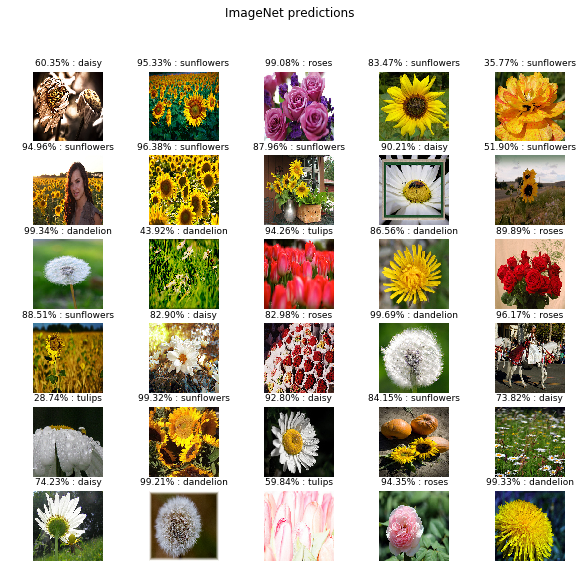

In [51]:
classes_names = list(image_data.class_indices.keys())
result_batch = new_model.predict(image_batch)
labels_batch = [(classes_names[np.argmax(item)], np.max(item)) for item in result_batch]

plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title("{0:>6.2%} : {1}".format(labels_batch[n][1], labels_batch[n][0]), size=9)
    plt.axis('off')
    plt.suptitle("ImageNet predictions")    
plt.show()

Явно стало лучше :) 

Обратите внимание на следущую вещь. Мы в этой тетрадке наплевали вообще на всё. Мы не выделили никакой тестовой выборки, никакой валидации на каждом шаге, чтобы застраховаться от переобучения. Это очень плохая практика. 

__Задание 1:__ разбить всё выборку на две папки: обучающую и тестовую. Создать два генератора. Один для тестовой выборки, другой для обучающей. По-нормальному обучить модель. Попробуйте использовать в качестве базовой модели не VGG-16, а какаю-нибудь другую модель. Можете делать это через `tensor-hub`. Как именно мы сейчас посмотрим. 

In [ ]:
# Код лучше для этого писать в новой тетрадке. Так сказать с чистого листа. 

__Задание 2:__ на лекции я сказал, что экстрактор фичей можно использовать для того, чтобы впоследствии обучать другие модели. Попробуйте сварить фичи из экстрактора и обучить на их основе случайный лес. Сравните на тесте качество нейронки с качеством случайного леса. 

In [ ]:
# Код для этого лучше продолжить писать в новой тетрадке.

# 2. Tensorhub 

## 2.1 Собираем модель

В $2017$ году Google сделал специальную платформу __TensorFlow Hub.__  Она используется для того, чтобы делиться друг с другом моделями. В таком формате свои результаты сохраняют различные исслодовательские группы. В том числе Россияская группа IPavlov. В следующие разы мы будем воровать у них модели через эту библиотечку. 

Для работы библиотеки нужна версия tensorflow выше `1.7`. Инструкцию по установке можно найти на [сайте tensorflow.](https://www.tensorflow.org/hub/installation)

В случае проблем с установкой, повысить версию tensorflow до актуальной помогает команда:

```python3 -m pip install --upgrade https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-1.12.0-py3-none-any.whl```


In [52]:
import tensorflow as tf
import tensorflow_hub as hub

print(tf.__version__)

W0513 09:16:57.542345 140736315745216 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


1.13.1


По [ссылке](https://tfhub.dev) можно найти зоопарк моделей от Google для открытого использования через библиотеку. Мы выберем среди всего этого огромного числа моделек что-нибудь новенькое. Например, архитектуру [MobileNetV2,](https://arxiv.org/abs/1801.04381) обученную Google в апреле 2018 года на ImageNet. Эта сетка - развитие Inception. Подробнее про неё можно почитать либо в [оригинальной статье,](https://arxiv.org/abs/1801.04381) либо [на Хабре.](https://habr.com/ru/post/352804/)

Сетка подгружается библиотекое tensorflow_hub просто по ссылке. Дальше мы можем завернуть её в удобную функцию и начать применять. 

In [53]:
# Ссылка на модель на хабе
classifier_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/2" 

# завернём модель в функцию и попробуем применить к какой-нибудь фотке
def classifier(x):
    classifier_module = hub.Module(classifier_url)
    return classifier_module(x)

In [54]:
# выясняем с какими размерностями работает модель
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(classifier_url))
IMAGE_SIZE

[224, 224]

Из-за того, что мы берём сетку не из керасовского API, нам придётся писать для её реализации чуть более сложный код. Первым шагом нам нужно запихнуть сетку внутрь Keras. Сделать это можно с помощью [лямбда-слоя.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda) С помощью такого слоя можно сделать частью нейросетки любое придуманное нами выражение. 

In [55]:
from tensorflow.keras import layers

# собираем нейросетку, где в качестве первого слоя берём нейросетку classifier
classifier_layer = layers.Lambda(classifier, input_shape = IMAGE_SIZE + [3])
classifier_model = tf.keras.Sequential([classifier_layer])
classifier_model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 09:17:05.480291 140736315745216 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1001)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [56]:
# input shape такой, потому что три канала
IMAGE_SIZE + [3]

[224, 224, 3]

Инициализируем сессию в tensorflow с Keras в качестве бэкэнда. 

In [57]:
import tensorflow.keras.backend as K

sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

Запустим сетку на изображении. 

In [61]:
grace_hopper = PIL.Image.open('/Users/fulyankin/.keras/datasets/image.jpg').resize(IMAGE_SIZE)

grace_hopper = np.array(grace_hopper)/255.0

result = classifier_model.predict(grace_hopper[np.newaxis, ...])

predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

Осталось только понять что это за класс такой.  Для хаба нет удобной функции, как для VGG. Не беда, скачаем метки классов для ImageNet вручную.

In [62]:
labels_href = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', labels_href)
imagenet_labels = np.array(open(labels_path).read().splitlines())

И посмотрим на результат прогноза

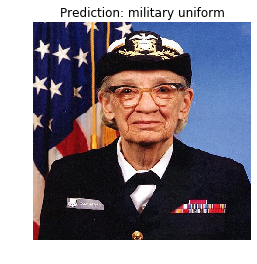

In [63]:
import matplotlib.pylab as plt

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
plt.title("Prediction: " + predicted_class_name)
plt.show()

__Military uniform.__ Очень недурно. При желании вы можете помотреть как сетка ведёт себя на других изображениях, а также вывести $5$ классов вместо одного. Функция для этого у вас уже есть выше. В ней надо только классификатор поменять. 

In [64]:
# Попробуйте сделать это 

Окей. Давайте попробуем посмотреть как нейросетка будет вести себя на изображениях с цветами. 

In [65]:
# построим прогнозы по батчу из картинок
result_batch = classifier_model.predict(image_batch)

# што там у нас спрогнозировалось? 
labels_batch = imagenet_labels[np.argmax(result_batch, axis=-1)]
labels_batch

array(['dung beetle', 'daisy', 'bakery', 'daisy', 'ant', 'apiary',
       'daisy', 'vase', 'daisy', 'rapeseed', 'ringlet', 'bee', 'daisy',
       'daisy', 'velvet', 'daisy', 'daisy', 'strawberry',
       'Bedlington terrier', 'horse cart', 'hair slide', 'daisy', 'daisy',
       'acorn', 'American egret', 'daisy', 'daisy', 'handkerchief', 'bee',
       'daisy', 'bee', 'daisy'], dtype='<U30')

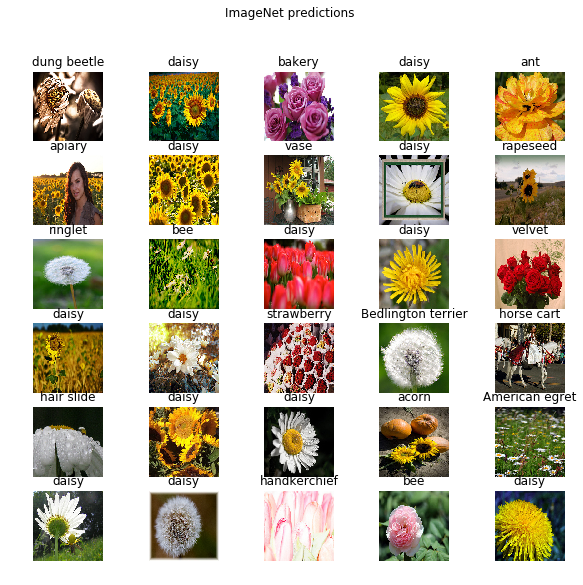

In [66]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(labels_batch[n])
    plt.axis('off')
    plt.suptitle("ImageNet predictions")    
plt.show()

Результаты далеки от совершенства, но разумны, учитывая, что это не те классы, для которых обучалась модель (кроме "daisy").

## 2.2 Дообучаем сетку

In [67]:
# нам для дообучения понадобится только feature extractor, скачаем его в hub
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2"

# завернём как и выше в функцию 
def feature_extractor(x):
    feature_extractor_module = hub.Module(feature_extractor_url)
    return feature_extractor_module(x)

# и вытащим размерности для входа
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))

Ещё раз убедимся, что с генератором всё в порядке и он выдаёт нам нужные размерности.

In [68]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)

for image_batch,label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Labe batch shape: ", label_batch.shape)
    break

Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 5)


In [69]:
# Оформляем feature_extractor как отдельный слой для сетки
features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])

In [70]:
# запрещаем нейросетке тренировать этот слой
features_extractor_layer.trainable = False

In [71]:
# собираем модель, на последний слой вытаскиваем softmax на 5 классов
model = tf.keras.Sequential([
  features_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 09:17:43.462464 140736315745216 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 6405      
Total params: 6,405
Trainable params: 6,405
Non-trainable params: 0
_________________________________________________________________


In [72]:
# инициализация весов
init = tf.global_variables_initializer()
sess.run(init)

In [73]:
# проверяем запускается ли модель, которую мы собрали и что она выдаёт на выходе
result = model.predict(image_batch)
result.shape

(32, 5)

In [74]:
# компилируем модель
model.compile(
  optimizer=tf.train.AdamOptimizer(), 
  loss='categorical_crossentropy',
  metrics=['accuracy'])

# будем собирать все данные об обучении на каждом батче в 
# специальный колбэк (помните, у нас был колбэк - early_stoping) 
# и я говорил, что можно писать свои колбэки на любой вкус и цвет,
# чтобы как-то наблюдать или контролировать обучение

class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])


# число шагов до конца первой эпохи
steps_per_epoch = image_data.samples//image_data.batch_size

batch_stats = CollectBatchStats() # объявили колбэк

# учим сетку одну эпоху
model.fit((item for item in image_data), 
                    epochs=1, 
                    steps_per_epoch = steps_per_epoch,
                    callbacks = [batch_stats])

114/114 [==============================] - 97s 852ms/step - loss: 0.6772 - acc: 0.7545


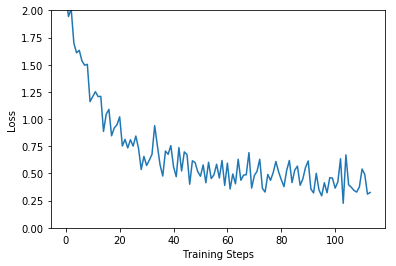

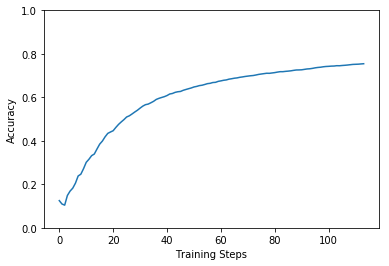

In [75]:
# вытаскиваем из колбэка информацию про обучение сетки 
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)

plt.show()

Строим прогнозы.

In [76]:
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [77]:
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch

array(['Tulips', 'Daisy', 'Dandelion', 'Roses', 'Daisy', 'Dandelion',
       'Roses', 'Roses', 'Dandelion', 'Roses', 'Dandelion', 'Daisy',
       'Roses', 'Tulips', 'Tulips', 'Sunflowers', 'Tulips', 'Tulips',
       'Roses', 'Dandelion', 'Sunflowers', 'Dandelion', 'Tulips',
       'Dandelion', 'Tulips', 'Tulips', 'Tulips', 'Daisy', 'Tulips',
       'Tulips', 'Tulips', 'Tulips'], dtype='<U10')

Рисуем их на картинке.

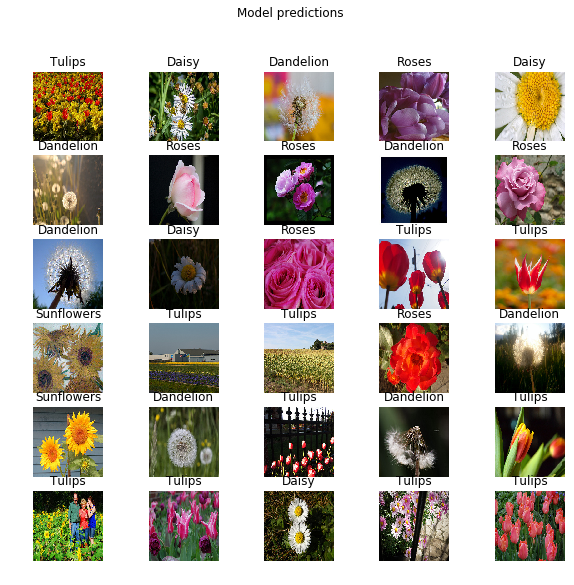

In [78]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(labels_batch[n])
    plt.axis('off')
    plt.suptitle("Model predictions")

plt.show()

Сохраняем дообученную сетку на свой компьютер.

In [79]:
export_path = tf.contrib.saved_model.save_keras_model(model, "./saved_models")
export_path


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


W0513 09:19:39.208209 140736315745216 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/network.py:1436: update_checkpoint_state (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 09:19:42.562937 140736315745216 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


W0513 09:19:44.042808 140736315745216 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:257: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0513 09:19:44.045122 140736315745216 export.py:587] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0513 09:19:44.046185 140736315745216 export.py:587] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


I0513 09:19:44.047363 140736315745216 export.py:587] Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


I0513 09:19:44.048462 140736315745216 export.py:587] Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


I0513 09:19:44.050352 140736315745216 export.py:587] Signatures INCLUDED in export for Eval: None


W0513 09:19:44.052796 140736315745216 tf_logging.py:161] Export includes no default signature!


INFO:tensorflow:No assets to save.


I0513 09:19:44.653940 140736315745216 builder_impl.py:629] No assets to save.


INFO:tensorflow:No assets to write.


I0513 09:19:44.655375 140736315745216 builder_impl.py:124] No assets to write.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 09:19:47.751685 140736315745216 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0513 09:19:49.409200 140736315745216 export.py:587] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0513 09:19:49.410669 140736315745216 export.py:587] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


I0513 09:19:49.411805 140736315745216 export.py:587] Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


I0513 09:19:49.412932 140736315745216 export.py:587] Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']


I0513 09:19:49.414961 140736315745216 export.py:587] Signatures INCLUDED in export for Eval: ['eval']


W0513 09:19:49.416102 140736315745216 tf_logging.py:161] Export includes no default signature!


INFO:tensorflow:No assets to save.


I0513 09:19:50.028435 140736315745216 builder_impl.py:629] No assets to save.


INFO:tensorflow:No assets to write.


I0513 09:19:50.030362 140736315745216 builder_impl.py:124] No assets to write.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 09:19:53.249783 140736315745216 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0513 09:19:54.125706 140736315745216 export.py:587] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0513 09:19:54.127542 140736315745216 export.py:587] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


I0513 09:19:54.128576 140736315745216 export.py:587] Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


I0513 09:19:54.130332 140736315745216 export.py:587] Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


I0513 09:19:54.132102 140736315745216 export.py:587] Signatures INCLUDED in export for Eval: None


INFO:tensorflow:No assets to save.


I0513 09:19:54.751682 140736315745216 builder_impl.py:629] No assets to save.


INFO:tensorflow:No assets to write.


I0513 09:19:54.753035 140736315745216 builder_impl.py:124] No assets to write.


INFO:tensorflow:SavedModel written to: ./saved_models/1557728377/saved_model.pb


I0513 09:19:55.270720 140736315745216 builder_impl.py:414] SavedModel written to: ./saved_models/1557728377/saved_model.pb


b'./saved_models/1557728377'

Вот такие вот дела. В следущей тетрадке мы продолжим заниматься `transfer_learning`, но на этот раз будем вместо задачи класификации решать более сложную задачку, локализации. 

## Почиташки 

Делал этут тетрадку на основе двух туториалов: 

* [Первый,](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/10_Fine-Tuning.ipynb)  на этом гитхабе довольно большое количество крутых тетрадок про нейронки. Рекомендую позалипать на них. 
* [Документация Tensorflow_Hub](https://www.tensorflow.org/hub)
* [Восхваление библиотеки на медиуме](https://neurohive.io/ru/frameworki/vvedenie-v-tensorflow-hub-biblioteku-modulej-mashinnogo-obuchenija-dlja-tensorflow/)
* [Пример извлечения фичей для SWM из нейронки](https://www.kaggle.com/craigglastonbury/using-inceptionv3-features-svm-classifier)